In [28]:
from pathlib import Path
import os
import sys

sys.path.append(Path(os.path.abspath('')).parent.parent)
os.chdir(Path(os.path.abspath('')).parent.parent)

import numpy as np
import pandas as pd 
import xarray as xr
from sklearn.linear_model import LinearRegression
import geopandas as gpd 
from shapely import box
from scipy.stats import norm
import config.settings as cset

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from config.settings import (labelsize_small, 
                            labelsize_medium, 
                            labelsize_large,
                            )

from tqdm.notebook import tqdm


plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['hatch.linewidth'] = cset.hatch_linewidth 
# Set global linewidth for all plotted lines
mpl.rcParams['lines.linewidth'] = cset.linewidth  # adjust as needed

# Set global linewidth for figure borders (spines)
mpl.rcParams['axes.linewidth'] = cset.border_linewidth   # frame around plots
mpl.rcParams['xtick.labelsize'] = labelsize_small
mpl.rcParams['ytick.labelsize'] = labelsize_small
mpl.rcParams['axes.labelsize'] = labelsize_medium
mpl.rcParams['axes.titlesize'] = labelsize_large
mpl.rcParams['legend.fontsize'] = labelsize_medium

mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.pad'] = 1


In [29]:
# Function to extract per-ensemble-member country median for each scenario group
def get_ensemble_medians(df, dataset_label):
    rows = []
    for scenario_prefix in cset.scenarios:  # Add more as needed
        scenario_cols = [col for col in df.columns if col.startswith(scenario_prefix)]
        for col in scenario_cols:
            country_median = df[col].median()
            rows.append({
                'Scenario': scenario_prefix,
                'EnsembleMember': col,
                'MedianValue': country_median,
                'Dataset': dataset_label
            })
    return pd.DataFrame(rows)

## Settings

In [30]:
thrshld = 1.35
thrshld_str = '135'
gmt_char = 'gmt_ntwr'

In [31]:
damage_fn_markers = {
    label: marker for label, marker in zip(
        cset.GDP_labels,
        ['s', 'o', 'd']  # Extend this list if needed
    )
}
linestyles = dict(zip(cset.GDP_labels, [(0, (1,1)), '-', (0, (5,1))]))

current_warming_rate_median = 0.27
current_warming_rate_ranges = [0.2,0.4]

## Load Data

In [32]:
peak_gdp_impacts = [pd.read_csv(cset.path_OUT_PW / file, index_col = 0) for file in cset.PW_dataset_names]
gmt_char_df = pd.read_csv(cset.path_MESMER_char / f'gmt_characteristics_thsld_{thrshld_str}.csv', index_col = 0)
gmt_char_df['gmt_ntwr'] *= 10 # convert to °C/decade
gmt_char_df['gmt_ltwr'] *= 10 # convert to °C/decade

In [33]:
gdp_dfs = [pd.read_csv(cset.path_INTERIM_GDP / file_name) for file_name in cset.GDP_interim_dataset_names]
gdp_impacts_2100 = [gdp_df[gdp_df.year == 2100].pivot(index='iso', columns='scen_run', values='SSP2_diff') for gdp_df in gdp_dfs]
del gdp_dfs

## Generate Results for Plotting

In [23]:
# Combine medians for all datasets
ensemble_medians_df = pd.concat([
    get_ensemble_medians(df, f'{cset.GDP_labels[i]}')
    for i, df in enumerate(gdp_impacts_2100)
])

# plotting mean warming between 2015-2030 against median GDP impacts dring peak warming year 
ensemble_medians_df['gmt_ntwr'] = gmt_char_df.loc[ensemble_medians_df.EnsembleMember.values, 'gmt_ntwr'].values # warming per decade
ensemble_medians_df['gmt_ltwr'] = gmt_char_df.loc[ensemble_medians_df.EnsembleMember.values, 'gmt_ltwr'].values # warming per decade
ensemble_medians_df['MedianValue'] *= 100 # convert to percent
## Store Results
quantiles = [0.05, 0.5, 0.95]
df = ensemble_medians_df.copy()
df['Scenario'] = df['Scenario'].map(cset.scenario_names_dict)
df['MedianValue'] -= 100
summary_2100_df = (
    df
    .groupby(['Scenario', 'Dataset'])['MedianValue']
    .quantile(quantiles)
    .unstack(level=-1)  # move quantiles from index to columns
    .reset_index()
    .set_index('Scenario')
    .rename(columns={0.05: 'q05', 0.5: 'median', 0.95: 'q95'})
    .round(1)
)
del df

In [24]:
# Combine medians for all datasets
ensemble_medians_df = pd.concat([
    get_ensemble_medians(df, f'{cset.GDP_labels[i]}')
    for i, df in enumerate(peak_gdp_impacts)
])

# plotting mean warming between 2015-2030 against median GDP impacts dring peak warming year 
ensemble_medians_df['gmt_ntwr'] = gmt_char_df.loc[ensemble_medians_df.EnsembleMember.values, 'gmt_ntwr'].values # warming per decade
ensemble_medians_df['gmt_ltwr'] = gmt_char_df.loc[ensemble_medians_df.EnsembleMember.values, 'gmt_ltwr'].values # warming per decade
ensemble_medians_df['MedianValue'] *= 100 # convert to percent

## Store Results
quantiles = [0.05, 0.5, 0.95]
df = ensemble_medians_df.copy()
df['Scenario'] = df['Scenario'].replace(cset.scenario_names_dict)
df['MedianValue'] -= 100
summary_peak_df = (
    df
    .groupby(['Scenario', 'Dataset'])['MedianValue']
    .quantile(quantiles)
    .unstack(level=-1)  # move quantiles from index to columns
    .reset_index()
    .set_index('Scenario')
    .rename(columns={0.05: 'q05', 0.5: 'median', 0.95: 'q95'})
    .round(1)
)

del df

### LATEX TABLE

In [25]:
from tabulate import tabulate
Path(cset.path_LATEX_TABLES).mkdir(parents=True, exist_ok=True)

with open(cset.latex_pw_summary_file, 'w') as f:
    f.write(tabulate(summary_peak_df, tablefmt='latex'))

with open(cset.latex_2100_summary_file, 'w') as f:
    f.write(tabulate(summary_2100_df, tablefmt='latex'))

### LATEX TABLE FOR REGRESSION ANALYISS 

In [26]:
from sklearn.linear_model import LinearRegression
from scipy import stats
import pandas as pd
import numpy as np

results = []
df = ensemble_medians_df.copy()
for scenario in cset.scenarios:
    for dataset in cset.GDP_labels:
        scenario_subset = df[
            (df['Dataset'] == dataset) &
            (df['Scenario'] == scenario)
        ]
        x_vals = scenario_subset['gmt_ntwr'].values
        y_vals = scenario_subset['MedianValue'].values-100

        if len(x_vals) > 1:
            # Perform linear regression
            model = LinearRegression()
            model.fit(x_vals.reshape(-1, 1), y_vals)
            y_pred = model.predict(x_vals.reshape(-1, 1))

            # Compute regression stats
            slope = model.coef_[0]
            intercept = model.intercept_
            r_value = np.corrcoef(x_vals, y_vals)[0, 1]
            r_squared = r_value**2

            # Compute standard error and p-value using scipy linregress
            slope_scipy, intercept_scipy, r_val, p_val, stderr = stats.linregress(x_vals, y_vals)

            results.append({
                'Scenario': scenario,
                'Dataset': dataset,
                'Slope': round(slope_scipy, 2),
                'StdErr': round(stderr, 2),
                'p_value': round(p_val, 2),
                'R_squared': round(r_squared, 2)
            })

# Convert to DataFrame
regression_summary = pd.DataFrame(results)
regression_summary['Scenario'] = regression_summary['Scenario'].replace(cset.scenario_names_dict)
regression_summary = regression_summary.set_index('Scenario')

# Optional: sort for easier reading
#regression_summary = regression_summary.sort_values(by=['Scenario', 'Dataset']).reset_index(drop=True)

In [11]:
with open(cset.latex_regression_ntwr_summary_file, 'w') as f:
    f.write(tabulate(regression_summary, tablefmt='latex'))

In [ ]:
classification_dfs = [pd.read_csv(cset.path_CLUSTER_results / f'Classification_{file_name}') for file_name in cset.GDP_interim_dataset_names]

scenarios_of_interest = ['Ref', 'Ren', 'GS', 'ModAct', 'CurPol']

summary_rows = []

for df, name in zip(classification_dfs, cset.GDP_labels):
    # Filter for scenarios of interest
    df_filtered = df[df['scen'].isin(scenarios_of_interest)]
    
    # Count how many countries are in 'nogrowth' per scen–run
    nogrowth_counts = (
        df_filtered[df_filtered['category'] == 'nogrowth']
        .groupby(['scen', 'run'])['iso']
        .nunique()
        .reset_index(name='nogrowth_country_count')
    )

    # Compute quantiles over those counts per scenario
    quantiles = (
        nogrowth_counts
        .groupby('scen')['nogrowth_country_count']
        .quantile([0.05, 0.5, 0.95])
        .unstack()
        .reset_index()
        .rename(columns={0.05: 'q05', 0.5: 'median', 0.95: 'q95'})
    )

    # Add dataset name
    quantiles['Dataset'] = name
    summary_rows.append(quantiles)

# Combine all into a single DataFrame
nogrowth_counts_df = pd.concat(summary_rows, ignore_index=True)

# Clean up column names and order
nogrowth_counts_df.rename(columns={'scen': 'Scenario'}, inplace=True)
nogrowth_counts_df = nogrowth_counts_df[['Scenario', 'Dataset', 'q05', 'median', 'q95']]
nogrowth_counts_df[['q05', 'median', 'q95']] = nogrowth_counts_df[['q05', 'median', 'q95']].round(1)
nogrowth_counts_df['Scenario'] = nogrowth_counts_df['Scenario'].replace(cset.scenario_names_dict)
nogrowth_counts_df = nogrowth_counts_df.set_index('Scenario')

with open(cset.latex_nogrowth_file , 'w') as f:
    f.write(tabulate(nogrowth_counts_df, tablefmt='latex'))

### Appendix Graphic

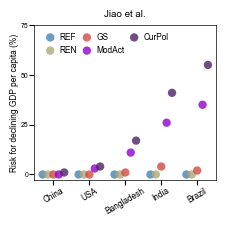

In [16]:
import matplotlib.pyplot as plt

# Scenarios and countries of interest
scenarios_of_interest = ['Ref', 'Ren', 'GS', 'ModAct', 'CurPol']
sel_isos = ['CHN', 'USA', 'BGD', 'IND', 'BRA']
iso_names = ['China', 'USA', 'Bangladesh', 'India', 'Brazil']

# Width of each dot group
x_offsets = np.linspace(0.2, 0.8, len(scenarios_of_interest))

# Use only the last classification_df
df = classification_dfs[-1]
title = cset.GDP_labels[-1]

# Filter to relevant scenarios
df = df[df['scen'].isin(scenarios_of_interest)]

# Group by scen and iso and count % nogrowth runs
nogrowth_share = (
    df.groupby(['scen', 'iso'])['category']
    .apply(lambda x: (x == 'nogrowth').mean() * 100)
    .unstack(level=0)  # columns: scenarios
    .loc[sel_isos]     # keep only selected countries
)

# Create single panel plot
fig, ax = plt.subplots(figsize=(cset.fig_width/3, cset.fig_height/3))

# Plot for each scenario
for i, scen in enumerate(scenarios_of_interest):
    ax.scatter(
        x_offsets[i] + np.arange(len(sel_isos)),
        nogrowth_share[scen].values,
        label=cset.scenario_names_dict.get(scen, scen),
        color=cset.scenarios_color_dict[scen],
        alpha=0.8,
        edgecolor='none',
    )

# Axis formatting
ax.set_xticks(np.arange(len(sel_isos)) + 0.5)
ax.set_xticklabels(iso_names, fontsize=labelsize_medium, rotation=30)
ax.set_yticks([0, 25, 50, 75], [0, 25, 50, 75], fontsize=labelsize_small)
ax.set_ylabel('Risk for declining GDP per capita (%)', fontsize=labelsize_medium)
ax.set_title(f'{title}', fontsize=labelsize_large)

# Legend
ax.legend(
    loc='upper left',
    ncols=3,
    edgecolor='none',
    facecolor=(1, 1, 1, 0.7),
    fontsize=labelsize_medium,
    handletextpad=0.1,
    columnspacing=0.2
)

plt.savefig(cset.path_GRAPHICS / f'nogrowth_risks_{title[:-1]}.pdf', bbox_inches='tight', dpi=300)
plt.tight_layout()

